In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/health-insurance-lead-prediction-raw-data/Health Insurance Lead Prediction Raw Data.csv


<h2>Import libraries</h2>

In [2]:
import warnings

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers


<h2>Functions definition</h2>

In [3]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def nan_perc(df):
    df_nan_perc = (100* df.isnull().sum() / len(df)).round(2)
    df_nan_perc.name = get_df_name(df) + " Nan(%)"
    return df_nan_perc.sort_values(ascending=False)

def mi_scores_cat(df, target):
    temp = df.copy()
    for colname in temp.select_dtypes(include='object'):
        temp[colname], _ = temp[colname].factorize()
    discrete_features = temp.dtypes == int
    mi_scores = mutual_info_classif(temp, target, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=temp.columns)
    del temp
    return mi_scores.sort_values(ascending=False)

def feat_pie(feat, feat_name=''):
    feat_percent = (feat.value_counts() / len(feat)).round(2)
    fig, axes = plt.subplots(1,1)
    axes.pie(feat_percent.values, labels=feat_percent.index, autopct="%1.1f%%" , shadow=True)
    axes.set_title(f'{feat_name} distribution')
    plt.show()
    
def num_distr_plotter(data, num_cols, target = None):
    rows = int(np.ceil(len(num_cols)/3))
    fig, axes = plt.subplots(rows, 3, figsize=(12,8))
    for col, ax in zip(num_cols, axes.ravel()):
        min_v = data[col].min()
        max_v = data[col].max()
        bins = np.linspace(min_v, max_v, 50)
        ax.hist(data[col], bins = bins, density=True, label = 'train')
        ax.set_xlabel(col)
        if ax == axes.flat[0] : ax.legend(loc = 'lower left')
        if target is not None:
            ax2 = ax.twinx()
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                total, _ = np.histogram(data[col], bins=bins)
                tar_val, _ = np.histogram(data[col][target == 1], bins=bins)
                ax2.scatter((bins[1:] + bins[:-1]) / 2, tar_val / total, color = 'r', s = 10, label = 'target probability')
                ax2.axhline(y = 0.5, color = 'r', linestyle = '--')
                ax2.set_ylim(0., 1.)
                ax2.tick_params(axis = 'y', color = 'r')
                if ax2 == axes.flat[0] : ax2.legend(loc = 'upper right')
    plt.tight_layout(w_pad = 1)
    plt.suptitle('Train distribution of the numerical features', fontsize=20, y=1.02)
    plt.show()

def cat_distr_plotter(data, cat_cols, target):
    rows = int(np.ceil(len(cat_cols)/3))
    fig, axes = plt.subplots(rows, 3, figsize=(12,8))
    for col, ax in zip(cat_cols, axes.ravel()):
        data_gb = target.groupby(data[col]).agg(['mean', 'size'])
        ax.bar(data_gb.index, data_gb['size'] / len(data),  label='train')
        ax.set_xlabel(col)
        if ax == axes.flat[0] : ax.legend(loc='lower left')
        ax.set_ylabel('frequency')
        ax2 = ax.twinx()
        ax2.scatter(data_gb.index, data_gb['mean'], color='r', label='target probability')
        ax2.axhline(y=0.5, color='r', linestyle='--')
        ax2.set_ylim(0., 1.)
        ax2.tick_params(axis='y', colors='r')
        if ax == axes.flat[0] : ax2.legend(loc='upper right')
    plt.tight_layout(w_pad=1)
    plt.suptitle('Train and test distributions of the categorical features', fontsize=20, y=1.02)
    plt.show()
    del data_gb

<h2>Look at data</h2>

In [4]:
train_df = pd.read_csv('/kaggle/input/health-insurance-lead-prediction-raw-data/Health Insurance Lead Prediction Raw Data.csv', index_col = 'ID')
train_df.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
ID,,,,,,,,,,,,,
1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50882 entries, 1 to 50882
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City_Code                50882 non-null  object 
 1   Region_Code              50882 non-null  int64  
 2   Accomodation_Type        50882 non-null  object 
 3   Reco_Insurance_Type      50882 non-null  object 
 4   Upper_Age                50882 non-null  int64  
 5   Lower_Age                50882 non-null  int64  
 6   Is_Spouse                50882 non-null  object 
 7   Health Indicator         39191 non-null  object 
 8   Holding_Policy_Duration  30631 non-null  object 
 9   Holding_Policy_Type      30631 non-null  float64
 10  Reco_Policy_Cat          50882 non-null  int64  
 11  Reco_Policy_Premium      50882 non-null  float64
 12  Response                 50882 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 5.4+ MB


In [6]:
train_df.nunique().sort_values(ascending=False)

Reco_Policy_Premium        6977
Region_Code                5316
Lower_Age                    60
Upper_Age                    58
City_Code                    36
Reco_Policy_Cat              22
Holding_Policy_Duration      15
Health Indicator              9
Holding_Policy_Type           4
Accomodation_Type             2
Reco_Insurance_Type           2
Is_Spouse                     2
Response                      2
dtype: int64

Checking the presence of null values, we see that almost 40% of 'Holding_Policy_Duration' and 'Holding_Policy_Type' entries are missing, as 23% of the health indicator:

In [7]:
nan_perc(train_df)

Holding_Policy_Duration    39.80
Holding_Policy_Type        39.80
Health Indicator           22.98
City_Code                   0.00
Region_Code                 0.00
Accomodation_Type           0.00
Reco_Insurance_Type         0.00
Upper_Age                   0.00
Lower_Age                   0.00
Is_Spouse                   0.00
Reco_Policy_Cat             0.00
Reco_Policy_Premium         0.00
Response                    0.00
Name: train_df Nan(%), dtype: float64

The target feature distribution is umbalanced, with only 24% of the target population showing interest to the offer:

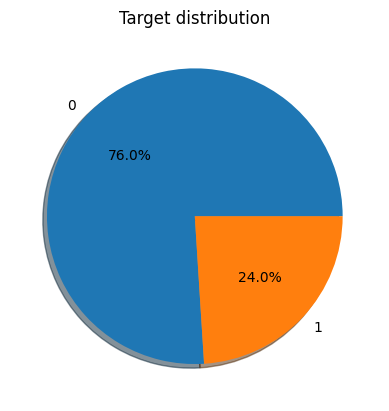

In [8]:
feat_pie(train_df['Response'], 'Target')

<h2>EDA</h2>

To perform data anlysis we first divide the dataset in a training and testing set to focus only on the training entries:

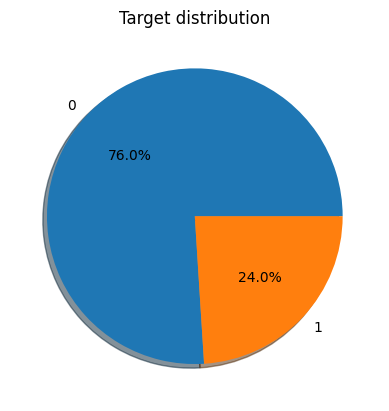

In [9]:
X = train_df.copy()
X.drop(['Response'], axis = 1, inplace = True)
y = train_df['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)
feat_pie(y_train, 'Target')
plt.show()


We make a distinction between numerical columns, categorical columns and low cardinality columns (useful for plotting):

In [10]:
cat_cols = [cname for cname in X.columns if X_train[cname].dtype == 'object' or X_train[cname].nunique() <= 10]
low_card_cols = [cname for cname in cat_cols if X_train[cname].nunique() <= 10] 
num_cols = [cname for cname in X.columns if X_train[cname].dtype in ['int64', 'float64'] and X_train[cname].nunique() > 10]
print('categorical features:\n', cat_cols)
print('-'*90)
print('numerical features:\n', num_cols)
print('-'*90)
print('low cardinality features:\n', low_card_cols)

categorical features:
 ['City_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type']
------------------------------------------------------------------------------------------
numerical features:
 ['Region_Code', 'Upper_Age', 'Lower_Age', 'Reco_Policy_Cat', 'Reco_Policy_Premium']
------------------------------------------------------------------------------------------
low cardinality features:
 ['Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Type']


<h3>Numerical features</h3>

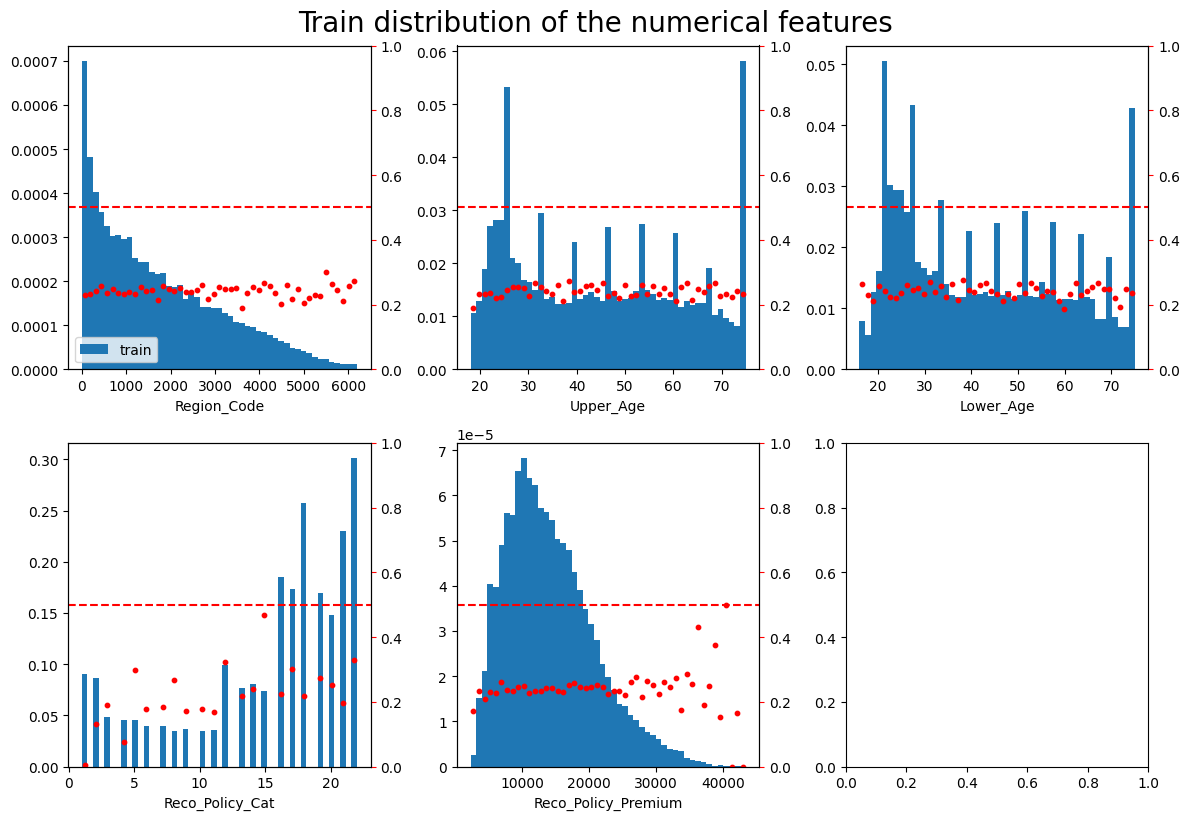

In [11]:
num_distr_plotter(X_train, num_cols, y_train)        

**Insights:**
<ul>
    <li>Some of the distribution are skewed.</li>
    <li>There is at most a small dependence between feature and target ptobability, with upper/lower age with no relation at all.</li>
</ul>

<h3>Categorical features</h3>

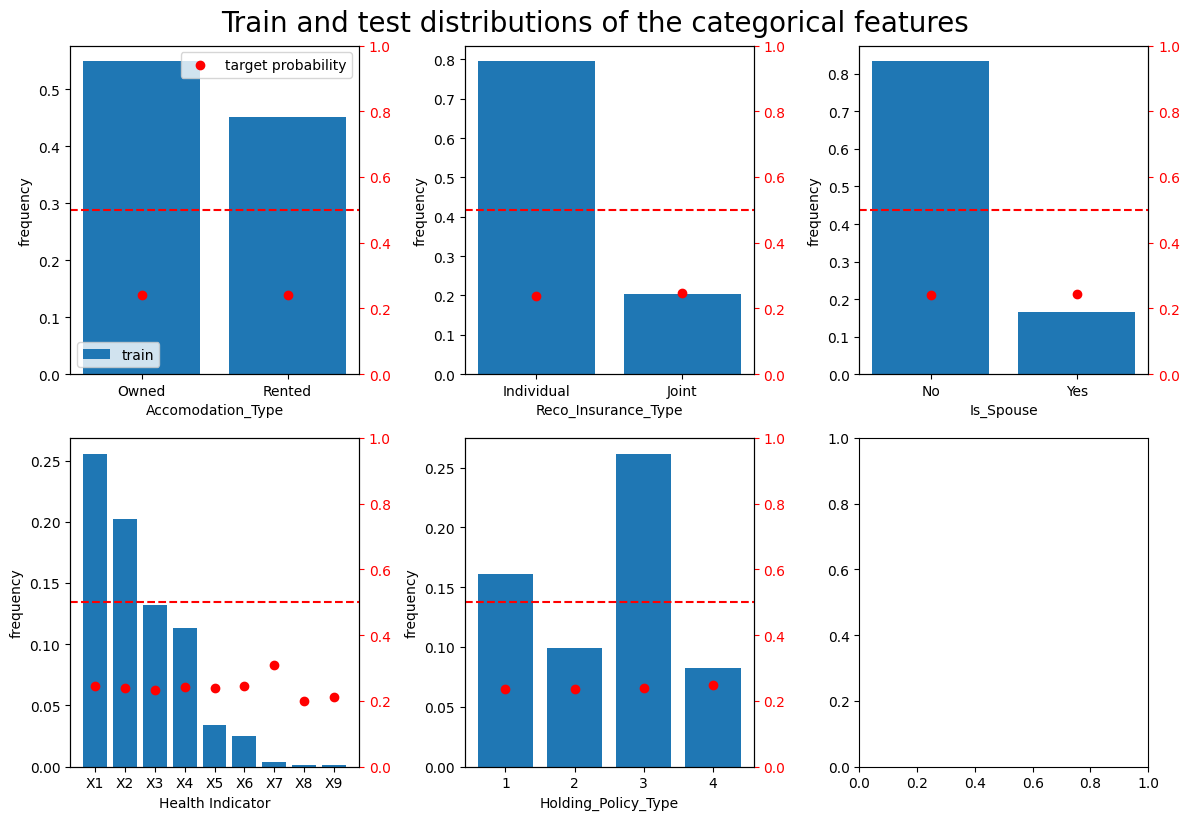

In [12]:
cat_distr_plotter(X_train,low_card_cols, y_train)

**Insights:**
<ul>
    <li>There's still no evident relation between features and target.</li>
</ul>

<Axes: >

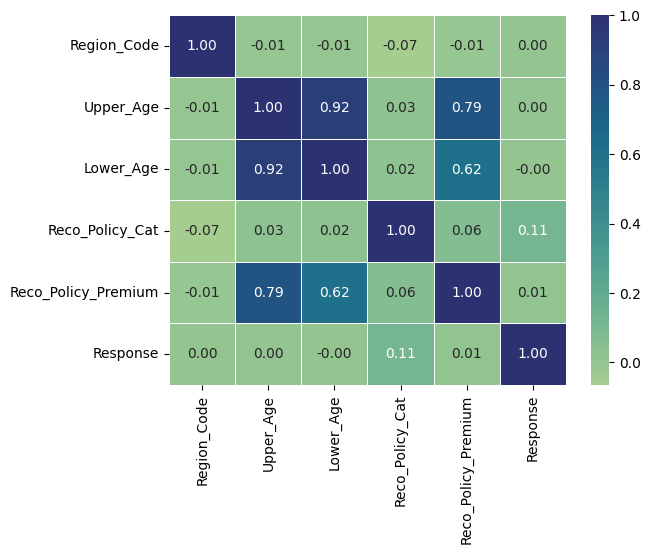

In [13]:
corr_matrix = train_df[num_cols + ['Response']].corr()
sns.heatmap(corr_matrix, cmap='crest', annot=True, fmt='.2f', linewidth=0.5)

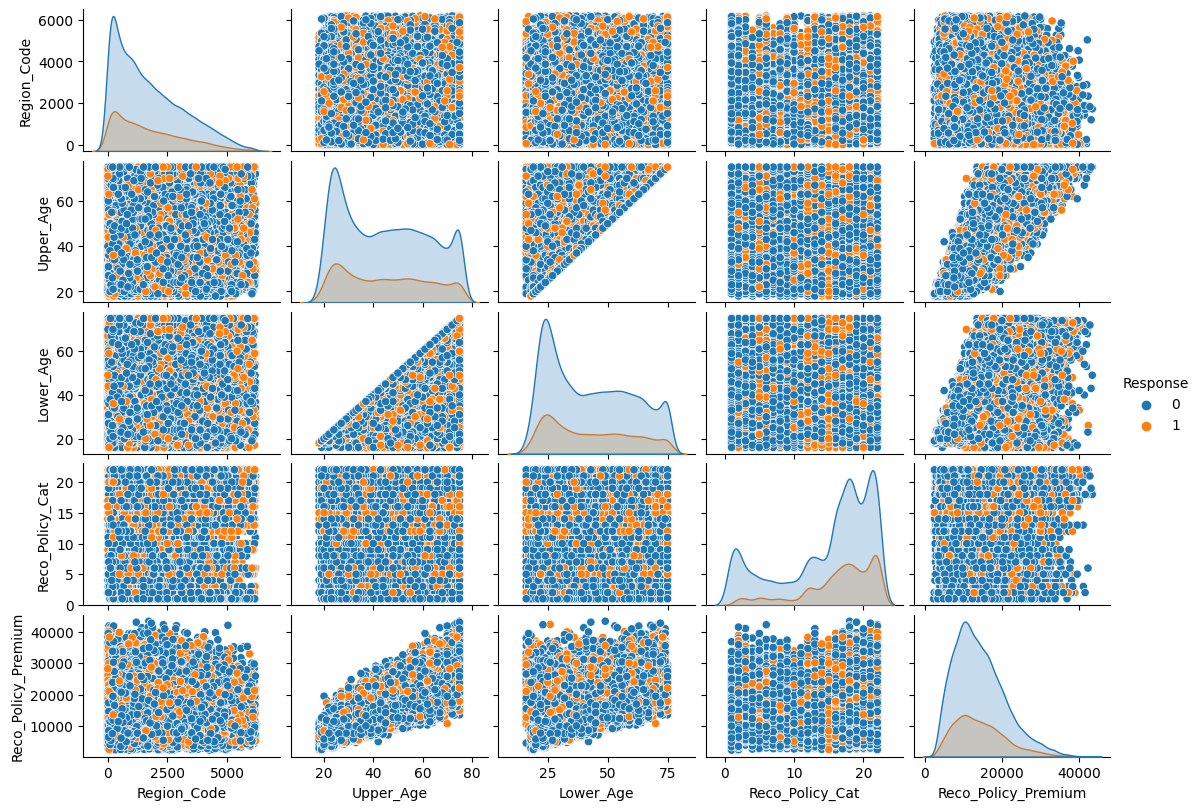

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    num_pp = sns.pairplot(data = train_df, vars = num_cols, hue='Response', dropna=True)
    num_pp.fig.set_size_inches(12,8)

<h2>Preprocessing</h2>

We first turn the city code values as numerical features (integers):

In [15]:
X_train['City_Code'] = X_train['City_Code'].apply(lambda x : int(x[1:]))
X_test['City_Code'] = X_test['City_Code'].apply(lambda x : int(x[1:]))
X_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
ID,,,,,,,,,,,,
39005,8,1843,Rented,Individual,51,51,No,X2,4.0,1.0,12,16380.0
19516,3,1246,Rented,Joint,58,57,Yes,X5,NaN,NaN,22,24024.0
18862,2,1373,Rented,Individual,23,23,No,X2,NaN,NaN,22,9380.0
47960,4,4874,Owned,Individual,49,49,No,NaN,1.0,1.0,2,11176.0
25174,14,2657,Owned,Joint,65,32,No,X4,7.0,4.0,17,25459.2


<h3>Filling missing values</h3>

Since the percentage of missing values is significant, we try to infer the null entries as follow, for each feature X with missing values:
<ul>
    <li>We select the dataset with missing values for X ($dataset[X == Nan]$).</li>
    <li>We choose the most common values $\vec{Y}_{common}$ for other features $\vec{Y}$, i.e. the most common features the missing-X population seem to share.</li>
    <li>We select the dataset with all these common values and choose the most frequent entry for X as value to substitute ($dataset[\vec{Y} == \vec{Y}_{common}][X].mode())$)  </li>
</ul>

The 'Holding_Policy_Duration' and 'Holding_Policy_Type' have missing values at the same indexes, so we can work for both of them at the same time, first let's see what's the typical profile for the population with these missing features:

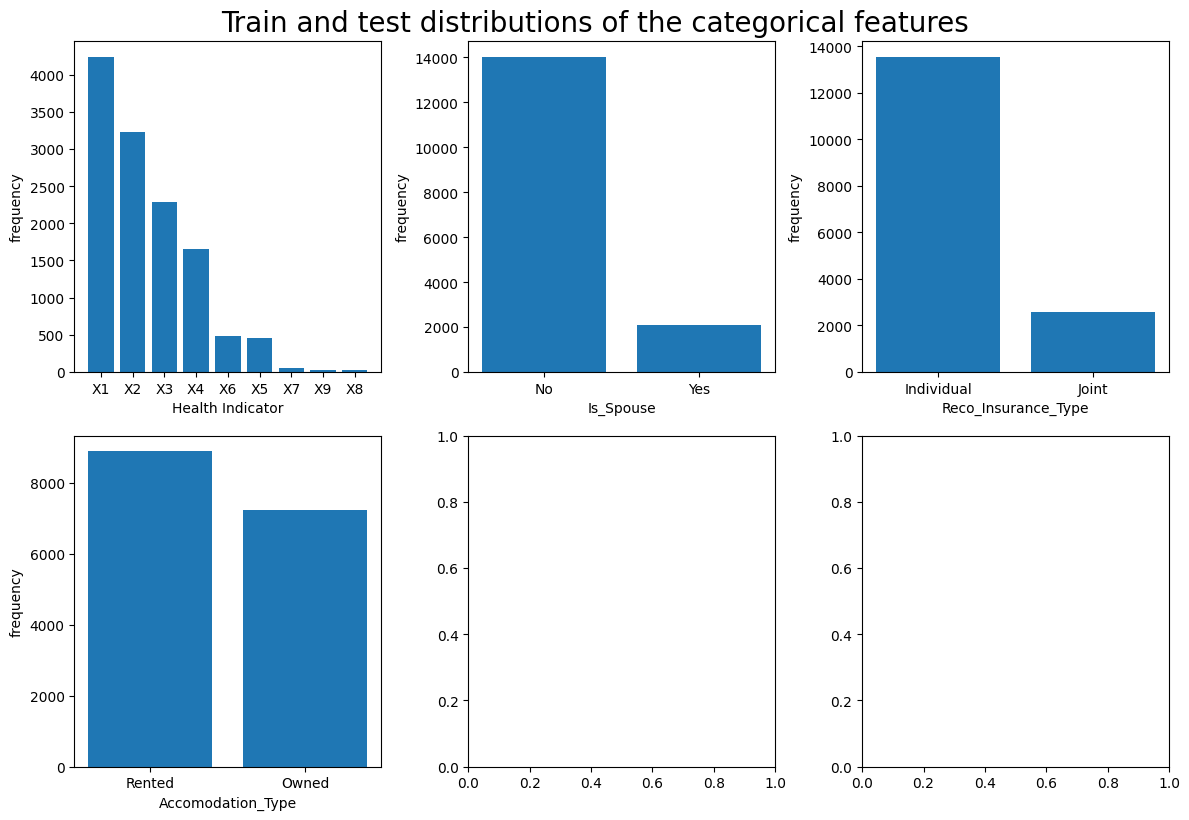

In [16]:
lc_nn_cols = list(set(low_card_cols) - set(['Holding_Policy_Duration', 'Holding_Policy_Type']))

def cat_plotter(data, cat_cols):
    rows = int(np.ceil(len(cat_cols)/3))
    fig, axes = plt.subplots(rows, 3, figsize=(12,8))
    for col, ax in zip(cat_cols, axes.ravel()):
        col_count = data[col].value_counts()
        ax.bar(col_count.index, col_count.values)
        ax.set_xlabel(col)
        ax.set_ylabel('frequency')
    plt.tight_layout(w_pad=1)
    plt.suptitle('Train and test distributions of the categorical features', fontsize=20, y=1.02)
    plt.show()

cat_plotter(X_train[X_train['Holding_Policy_Duration'].isnull()], lc_nn_cols)

We find that, most of the time:
<ul>
    <li>The offer was not offered as a joint offer with a spouse.</li>
    <li>The insurance type is individual.</li>
    <li>The most common health indicators are X1, X2 and X3</li>
</ul>
Observe that these are the same distributions of the entire dataset so we expect to obtain the same result as to just replace Nan with a most-frequent imputing.

In [17]:
spouse_mask = X_train['Is_Spouse'] == 'No'
rit_mask = X_train['Reco_Insurance_Type'] == 'Individual'
hi_mask = (X_train['Health Indicator'] == 'X1') | (X_train['Health Indicator'] == 'X2') | (X_train['Health Indicator'] == 'X3')
hpd_fill_val = X_train[spouse_mask & rit_mask & hi_mask].mode()['Holding_Policy_Duration'][0]
hpt_fill_val = X_train[spouse_mask & rit_mask & hi_mask].mode()['Holding_Policy_Type'][0]

We do the same with the health indicator:

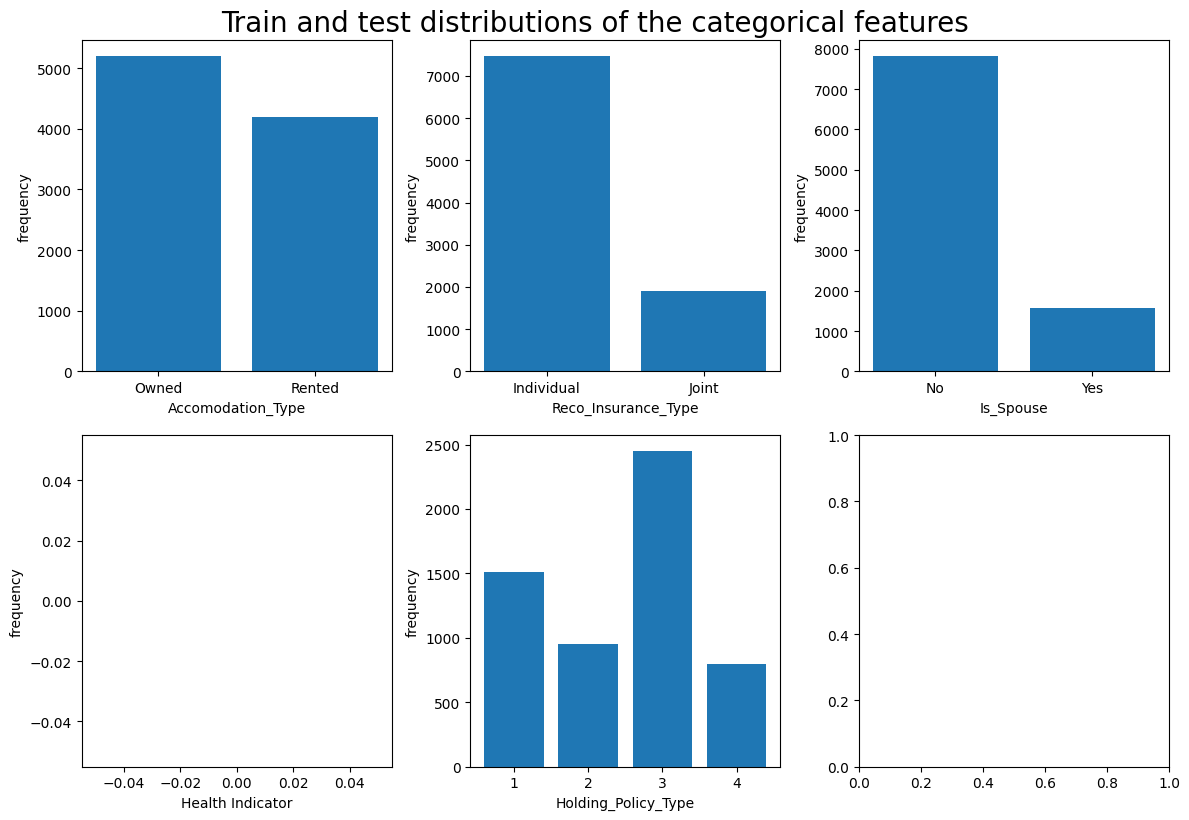

In [18]:
cat_plotter(X_train[X_train['Health Indicator'].isnull()], low_card_cols)

In [19]:
hpt_mask = X_train['Holding_Policy_Type'] == 3
hi_fill_val = X_train[spouse_mask & hpt_mask & rit_mask].mode()['Health Indicator'][0]

In [20]:
print('hpd_fill_val: ', hpd_fill_val)
print('hpt_fill_val: ', hpt_fill_val)
print('hi_fill_val: ', hi_fill_val)

hpd_fill_val:  1.0
hpt_fill_val:  3.0
hi_fill_val:  X1


We substitute the null entries with the values above:

In [21]:
X_train['Holding_Policy_Duration'] = X_train['Holding_Policy_Duration'].fillna(hpd_fill_val)
X_test['Holding_Policy_Duration'] = X_test['Holding_Policy_Duration'].fillna(hpd_fill_val)
X_train['Holding_Policy_Type'] = X_train['Holding_Policy_Type'].fillna(hpt_fill_val)
X_test['Holding_Policy_Type'] = X_test['Holding_Policy_Type'].fillna(hpt_fill_val)
X_train['Health Indicator'] = X_train['Health Indicator'].fillna(hi_fill_val)
X_test['Health Indicator'] = X_test['Health Indicator'].fillna(hi_fill_val)
nan_perc(X_train)

City_Code                  0.0
Region_Code                0.0
Accomodation_Type          0.0
Reco_Insurance_Type        0.0
Upper_Age                  0.0
Lower_Age                  0.0
Is_Spouse                  0.0
Health Indicator           0.0
Holding_Policy_Duration    0.0
Holding_Policy_Type        0.0
Reco_Policy_Cat            0.0
Reco_Policy_Premium        0.0
Name: X_train Nan(%), dtype: float64

In [22]:
X_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
ID,,,,,,,,,,,,
39005,8,1843,Rented,Individual,51,51,No,X2,4.0,1.0,12,16380.0
19516,3,1246,Rented,Joint,58,57,Yes,X5,1.0,3.0,22,24024.0
18862,2,1373,Rented,Individual,23,23,No,X2,1.0,3.0,22,9380.0
47960,4,4874,Owned,Individual,49,49,No,X1,1.0,1.0,2,11176.0
25174,14,2657,Owned,Joint,65,32,No,X4,7.0,4.0,17,25459.2


In [23]:
for X in [X_train, X_test]:
    X['Accomodation_Type'] = X['Accomodation_Type'].map({'Rented' : 0, 'Owned' : 1})
    X['Reco_Insurance_Type'] = X['Reco_Insurance_Type'].map({'Joint' : 0, 'Individual' : 1})
    X['Is_Spouse'] = X['Is_Spouse'].map({'No' : 0, 'Yes' : 1})
    X['Holding_Policy_Duration'] = X['Holding_Policy_Duration'].map({'1.0' : 1, '2.0' : 2, '3.0' : 3, '4.0': 4, '5.0': 5, '6.0': 6, '7.0': 7, '8.0': 8, '9.0': 9, '10.0': 10, '11.0': 11, '12.0': 12, '13.0': 13, '14.0': 14, '14+' : 14})
    X['Health Indicator'] = X['Health Indicator'].apply(lambda x : int(x[1:]))

X_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
ID,,,,,,,,,,,,
39005,8,1843,0,1,51,51,0,2,4,1.0,12,16380.0
19516,3,1246,0,0,58,57,1,5,1,3.0,22,24024.0
18862,2,1373,0,1,23,23,0,2,1,3.0,22,9380.0
47960,4,4874,1,1,49,49,0,1,1,1.0,2,11176.0
25174,14,2657,1,0,65,32,0,4,7,4.0,17,25459.2


In [24]:
for col in num_cols:
    X_train[col] = np.log(1 + X_train[col])
    X_test[col] = np.log(1 + X_test[col])

mm_scaler = MinMaxScaler()
X_train[num_cols] = mm_scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = mm_scaler.transform(X_test[num_cols])
X_train.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
ID,,,,,,,,,,,,
39005,8,0.849247,0,1,0.726256,0.746588,0,2,4,1.0,0.766395,0.669505
19516,3,0.800581,0,0,0.817358,0.819508,1,5,1,3.0,1.000000,0.799559
18862,2,0.812646,0,1,0.168517,0.230274,0,2,1,3.0,1.000000,0.480205
47960,4,0.970190,1,1,0.697964,0.720397,0,1,1,1.0,0.166015,0.539692
25174,14,0.894734,1,0,0.898233,0.442928,0,4,7,4.0,0.899637,0.819262


For the model training we use all the feature with the exception of 'Lower_Age' and 'Upper_Age' which seems uninformative.

In [25]:
my_features = ['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type', 'Is_Spouse', 'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat', 'Reco_Policy_Premium']
X_train = X_train[my_features]

<h2>Modelling</h2>

As model we select a fully connected Neural Network:

In [26]:
early_stopping = EarlyStopping(
min_delta = 0.001,
patience = 10,
restore_best_weights = True,)

model = keras.Sequential([
    layers.Input(shape = [X_train.shape[1]]),
    layers.Dense(200, activation='tanh'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(200, activation='tanh'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(200, activation='tanh'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['binary_accuracy'])

<h2>Training</h2>

In [27]:
history = model.fit(X_train, y_train,
                   epochs = 500,
                    batch_size = 256,
                   callbacks = [early_stopping],
                   validation_split = 0.2,
                   verbose = 1)

Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - binary_accuracy: 0.5961 - loss: 0.7151 - val_binary_accuracy: 0.7565 - val_loss: 0.5585
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7378 - loss: 0.5903 - val_binary_accuracy: 0.7565 - val_loss: 0.5555
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7477 - loss: 0.5757 - val_binary_accuracy: 0.7565 - val_loss: 0.5543
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7567 - loss: 0.5663 - val_binary_accuracy: 0.7565 - val_loss: 0.5530
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7609 - loss: 0.5540 - val_binary_accuracy: 0.7565 - val_loss: 0.5507
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7622 - loss: 0.5539 - val_binary_accuracy: 0.7565 - val_loss: 0.5518
Epoch 7/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7586 - loss: 0.5580 - val_binary_accuracy: 0.7565 - val_loss: 0.554

In [28]:
history_df = pd.DataFrame(history.history)
print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
             history_df['val_binary_accuracy'].max()))


Best Validation Loss: 0.5443
Best Validation Accuracy: 0.7565


Finally, we check the model performance on the testing dataset:

In [29]:
model.evaluate(X_test[my_features], y_test)

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7608 - loss: 0.5372


[0.5401290059089661, 0.7600471377372742]